In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

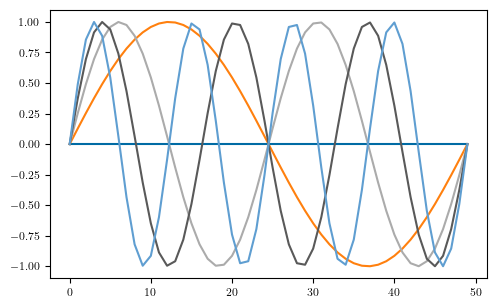

In [7]:
from os import path

# https://jwalton.info/Embed-Publication-Matplotlib-Latex/

PT_PER_INCH = 72.27
GOLDEN_RATIO = (5**.5 - 1) / 2

TEXTWIDTH_PT = 408.0 # \showthe\textwidth
TEXTWIDTH_IN = TEXTWIDTH_PT/PT_PER_INCH

REPORT_PATH = "report"
FIGURES_PATH = path.join("report", "figures")
STYLE_PATH = path.join("report", "thesis.mplstyle")

def figsize(fraction=1.0, width=TEXTWIDTH_IN, ratio=GOLDEN_RATIO, subplots=(1, 1)):
    fig_width = fraction*width
    fig_height = fig_width*ratio*(subplots[0]/subplots[1])
    return fig_width, fig_height

def figpath(name):
    return path.join(FIGURES_PATH, f"{name}.pgf")

plt.style.use(["default", "tableau-colorblind10", STYLE_PATH])
plt.figure(figsize=figsize())
for i in range(5):
    plt.plot(np.sin(np.linspace(0, i*2*np.pi)))
plt.show()


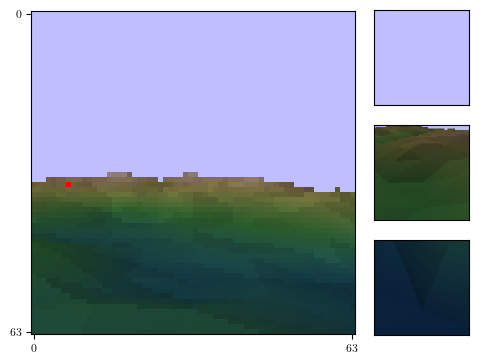

In [63]:
import gym
import gym_search


def plot_environment(env_id, seed=0, count=4, steps=10):
    layout = [
        [0, 0, 0, 1],
        [0, 0, 0, 2],
        [0, 0, 0, 3],
    ]

    fig, axs = plt.subplot_mosaic(layout, figsize=figsize(ratio=0.75))

    env = gym.make(env_id)

    for i in range(count):
        env.reset(seed=seed if i == 0 else None)
        env.plot(axs[i], overlay=(i == 0))

    return fig

#plot_environment("Gaussian-v0", seed=0).savefig(figpath("gaussian"), dpi=300)
#plot_environment("Terrain-v0", seed=0).savefig(figpath("terrain"), dpi=300)
plot_environment("Camera-v0", seed=0).savefig(figpath("camera"), dpi=300)

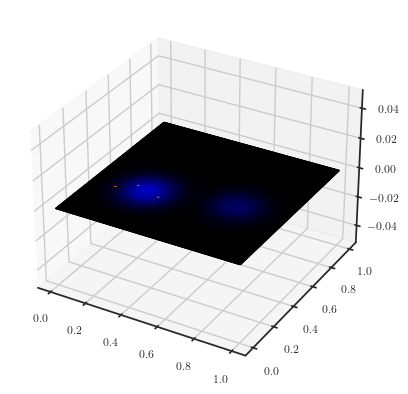

In [67]:
import gym
import gym_search

env = gym.make("SearchGaussian-v0")
obs = env.reset()
img = env.render(mode="rgb_array", show_view=False, show_targets=False, show_hits=False, show_path=False)

h, w, _c = img.shape

# https://stackoverflow.com/questions/25287861/creating-intersecting-images-in-matplotlib-with-imshow-or-other-function/25295272#25295272

fig = plt.figure()
ax = plt.axes(projection='3d')

#points = [(10, 20, 1), (4, 1, 3)]
#xs, ys, zs = zip(*points)
#ax.scatter(xs, ys, zs)
#ax.grid(False)

xx, yy = np.meshgrid(np.linspace(0, 1, h), np.linspace(0, 1, w))
zz = np.zeros((h, w))
ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, facecolors=img/255)

#view = env.view
#ax.add_patch(mpl.patches.Rectangle(view.position, *view.shape, linewidth=1, edgecolor="r"))

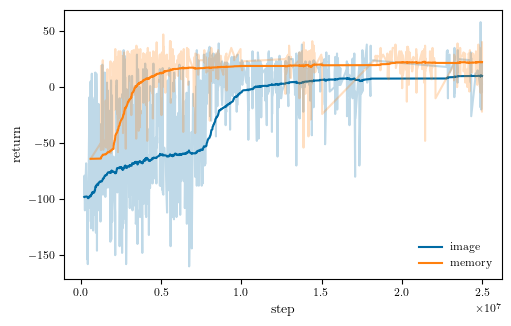

In [73]:
from scipy import stats

def smooth(scalars, weight):
    last = scalars[0]
    smoothed = []

    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

def plot_tboard(paths, labels, xlabel="step", ylabel="value", smoothing=0.0, original=False, outliers=False):
    fig, ax = plt.subplots(figsize=figsize())

    for path, label in zip(paths, labels):
        df = pd.read_csv(path)

        if not outliers:
            df = df[(np.abs(stats.zscore(df["Value"])) < 3)]

        x = df["Step"]
        y = df["Value"]

        p = ax.plot(x, smooth(list(y), smoothing), label=label)
        
        if original:
            ax.plot(x, y, alpha=0.25, color=p[0].get_color())

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(frameon=False)
    return fig

logs = ["logs/run-gaussian-image-tag-charts_episode_return.csv", "logs/run-gaussian-memory-tag-charts_episode_return.csv"]
labels = ["image", "memory"]

fig = plot_tboard(logs, labels, ylabel="return", smoothing=0.99, original=True)

In [63]:
import pandas as pd

def plot_hparams(hparams):
    df = pd.DataFrame({key: [value] for key, value in hparams.items()})
    return df.to_latex()

plot_hparams({"lr": 0.1, "steps": 10000})

,lr,steps
0,0.1,10000


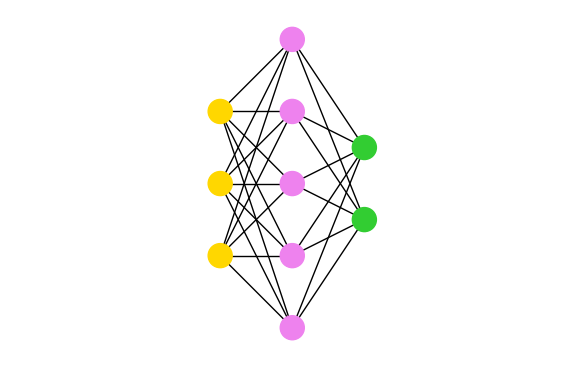

In [12]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx


def plot_ann():
    nodes = [3, 5, 2]
    colors = ["gold", "violet", "limegreen", "violet", "limegreen", "darkorange"]
    extents = nx.utils.pairwise(itertools.accumulate((0,) + tuple(nodes)))
    layers = [range(start, end) for start, end in extents]
    G = nx.Graph()
    
    for (i, layer) in enumerate(layers):
        G.add_nodes_from(layer, layer=i)
    for layer1, layer2 in nx.utils.pairwise(layers):
        G.add_edges_from(itertools.product(layer1, layer2))
    
    color = [colors[data["layer"]] for v, data in G.nodes(data=True)]
    pos = nx.multipartite_layout(G, subset_key="layer")
    plt.figure(figsize=figsize())
    nx.draw(G, pos, node_color=color, with_labels=False)
    plt.axis("equal")

plot_ann()

## rlliable

https://github.com/google-research/rliable

In [1]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

### Aggregate metrics with 95% Stratified Bootstrap CIs

In [ ]:
# IQM, Optimality Gap, Median, Mean

algorithms = ['DQN (Nature)', 'DQN (Adam)', 'C51', 'REM', 'Rainbow',
              'IQN', 'M-IQN', 'DreamerV2']
# Load ALE scores as a dictionary mapping algorithms to their human normalized
# score matrices, each of which is of size `(num_runs x num_games)`.
atari_200m_normalized_score_dict = ...
aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x),
  metrics.aggregate_optimality_gap(x)])
aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
  atari_200m_normalized_score_dict, aggregate_func, reps=50000)
fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['Median', 'IQM', 'Mean', 'Optimality Gap'],
  algorithms=algorithms, xlabel='Human Normalized Score')

# Probability of Improvement

# Load ProcGen scores as a dictionary containing pairs of normalized score
# matrices for pairs of algorithms we want to compare
procgen_algorithm_pairs = {.. , 'x,y': (score_x, score_y), ..}
average_probabilities, average_prob_cis = rly.get_interval_estimates(
  procgen_algorithm_pairs, metrics.probability_of_improvement, reps=2000)
plot_utils.plot_probability_of_improvement(average_probabilities, average_prob_cis)

### Sample Efficiency

In [ ]:
algorithms = ['DQN (Nature)', 'DQN (Adam)', 'C51', 'REM', 'Rainbow',
              'IQN', 'M-IQN', 'DreamerV2']
# Load ALE scores as a dictionary mapping algorithms to their human normalized
# score matrices across all 200 million frames, each of which is of size
# `(num_runs x num_games x 200)` where scores are recorded every million frame.
ale_all_frames_scores_dict = ...
frames = np.array([1, 10, 25, 50, 75, 100, 125, 150, 175, 200]) - 1
ale_frames_scores_dict = {algorithm: score[:, :, frames] for algorithm, score
                          in ale_all_frames_scores_dict.items()}
iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame])
                               for frame in range(scores.shape[-1])])
iqm_scores, iqm_cis = rly.get_interval_estimates(
  ale_frames_scores_dict, iqm, reps=50000)
plot_utils.plot_sample_efficiency_curve(
    frames+1, iqm_scores, iqm_cis, algorithms=algorithms,
    xlabel=r'Number of Frames (in millions)',
    ylabel='IQM Human Normalized Score')

### Performance Profiles

In [ ]:
# Load ALE scores as a dictionary mapping algorithms to their human normalized
# score matrices, each of which is of size `(num_runs x num_games)`.
atari_200m_normalized_score_dict = ...
# Human normalized score thresholds
atari_200m_thresholds = np.linspace(0.0, 8.0, 81)
score_distributions, score_distributions_cis = rly.create_performance_profile(
    atari_200m_normalized_score_dict, atari_200m_thresholds)
# Plot score distributions
fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
plot_utils.plot_performance_profiles(
  score_distributions, atari_200m_thresholds,
  performance_profile_cis=score_distributions_cis,
  colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
  xlabel=r'Human Normalized Score $(\tau)$',
  ax=ax)

# with non-linear scaling
plot_utils.plot_performance_profiles(
  perf_prof_atari_200m, atari_200m_tau,
  performance_profile_cis=perf_prof_atari_200m_cis,
  use_non_linear_scaling=True,
  xticks = [0.0, 0.5, 1.0, 2.0, 4.0, 8.0]
  colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
  xlabel=r'Human Normalized Score $(\tau)$',
  ax=ax)